In [94]:
import os
import sys
import numpy as np
import pandas as pd
import xlrd
from sklearn import preprocessing
from datetime import datetime, timedelta
import time
import re

In [95]:
def read_multiple_sheets(path):
    wb = xlrd.open_workbook(path)
    sheet_list = []
    sheet_list = [sheet.name for sheet in wb.sheets()]
    dict_all = {}
    for name in sheet_list:
        print('Start to read %s.' % name)
        dict_all[name] = pd.read_excel(path, sheet_name = name)
        print('Dataset: %s ==> %s\n' % (name, dict_all[name].shape))
    return dict_all, sheet_list

In [96]:
data_watching_info, sheet_watching_info = read_multiple_sheets('附件1：用户收视信息.xlsx')

Start to read 用户收视信息.
Dataset: 用户收视信息 ==> (361963, 6)

Start to read 用户回看信息.
Dataset: 用户回看信息 ==> (24660, 7)

Start to read 用户点播信息.
Dataset: 用户点播信息 ==> (836, 7)

Start to read 用户单片点播信息.
Dataset: 用户单片点播信息 ==> (38010, 7)



In [97]:
shoukan = data_watching_info[sheet_watching_info[0]]
shoukan.head()

,机顶盒设备号,统计日期,频道号,频道名,收看开始时间,收看结束时间
0,10001,20170701,1,中央1台-高清,2017-07-01 22:04:00,2017-07-01 22:08:00
1,10001,20170702,123,翡翠台,2017-07-02 09:30:00,2017-07-02 09:49:00
2,10001,20170702,1,中央1台-高清,2017-07-02 09:29:00,2017-07-02 09:30:00
3,10001,20170716,1,中央1台-高清,2017-07-16 21:59:00,2017-07-16 22:04:00
4,10001,20170716,1,中央1台-高清,2017-07-16 19:21:00,2017-07-16 19:23:00


In [98]:
shoukan = shoukan.drop_duplicates(['机顶盒设备号','统计日期','收看开始时间','收看结束时间'])
shoukan.head()

,机顶盒设备号,统计日期,频道号,频道名,收看开始时间,收看结束时间
0,10001,20170701,1,中央1台-高清,2017-07-01 22:04:00,2017-07-01 22:08:00
1,10001,20170702,123,翡翠台,2017-07-02 09:30:00,2017-07-02 09:49:00
2,10001,20170702,1,中央1台-高清,2017-07-02 09:29:00,2017-07-02 09:30:00
3,10001,20170716,1,中央1台-高清,2017-07-16 21:59:00,2017-07-16 22:04:00
4,10001,20170716,1,中央1台-高清,2017-07-16 19:21:00,2017-07-16 19:23:00


In [99]:
shoukan['频道号'].unique().shape, shoukan['频道名'].unique().shape

((157,), (146,))

In [100]:
shoukan['频道名'] = pd.Categorical(shoukan['频道名'])
shoukan['新频道号'] = shoukan['频道名'].cat.codes
shoukan['新频道号'].unique().shape

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(146,)

In [101]:
shoukan['收看时长'] = (shoukan['收看结束时间'] - shoukan['收看开始时间']).values/np.timedelta64(1, 's')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
#除去收看时长大于 16 小时的收视记录
shoukan = shoukan[shoukan['收看时长'].apply(lambda x:True if x<=10*3600 else False )]

In [103]:
print(shoukan.shape)
shoukan.head()

(350423, 8)


,机顶盒设备号,统计日期,频道号,频道名,收看开始时间,收看结束时间,新频道号,收看时长
0,10001,20170701,1,中央1台-高清,2017-07-01 22:04:00,2017-07-01 22:08:00,21,240.0
1,10001,20170702,123,翡翠台,2017-07-02 09:30:00,2017-07-02 09:49:00,128,1140.0
2,10001,20170702,1,中央1台-高清,2017-07-02 09:29:00,2017-07-02 09:30:00,21,60.0
3,10001,20170716,1,中央1台-高清,2017-07-16 21:59:00,2017-07-16 22:04:00,21,300.0
4,10001,20170716,1,中央1台-高清,2017-07-16 19:21:00,2017-07-16 19:23:00,21,120.0


In [76]:
shoukan.to_csv("shoukan.csv",encoding="utf8")

# 用户回看信息

In [105]:
huikan = data_watching_info[sheet_watching_info[1]]
huikan.head()

,设备号,统计时间,用户号,频道,回看开始时间,回看结束时间,回看时长.时.
0,10001,20170723,10853,东方卫视-高清,2017-07-22 23:02:56,2017-07-23 00:38:30,0.6417
1,10001,20170723,10853,东方卫视-高清,2017-07-22 23:02:56,2017-07-23 00:38:30,0.9511
2,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,2.0000
3,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,2.0000
4,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,1.8083


In [106]:
huikan = huikan.drop_duplicates(['设备号','统计时间','用户号','频道','回看开始时间','回看结束时间'])
print(huikan.shape)
huikan.head()

(16559, 7)


,设备号,统计时间,用户号,频道,回看开始时间,回看结束时间,回看时长.时.
0,10001,20170723,10853,东方卫视-高清,2017-07-22 23:02:56,2017-07-23 00:38:30,0.6417
2,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,2.0000
7,10004,20170813,10886,中央6台-高清,2017-08-13 13:01:04,2017-08-13 15:03:56,1.0656
9,10004,20170903,10886,深圳卫视-高清,2017-09-03 21:28:08,2017-09-03 22:04:26,0.0739
11,10004,20170923,10886,东方卫视-高清,2017-09-23 22:52:22,2017-09-23 23:27:07,0.5792


In [107]:
huikan['新回看时长'] = (huikan['回看结束时间'] - huikan['回看开始时间']).values/np.timedelta64(1, 's')
huikan.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,设备号,统计时间,用户号,频道,回看开始时间,回看结束时间,回看时长.时.,新回看时长
0,10001,20170723,10853,东方卫视-高清,2017-07-22 23:02:56,2017-07-23 00:38:30,0.6417,5734.0
2,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,2.0000,34597.0
7,10004,20170813,10886,中央6台-高清,2017-08-13 13:01:04,2017-08-13 15:03:56,1.0656,7372.0
9,10004,20170903,10886,深圳卫视-高清,2017-09-03 21:28:08,2017-09-03 22:04:26,0.0739,2178.0
11,10004,20170923,10886,东方卫视-高清,2017-09-23 22:52:22,2017-09-23 23:27:07,0.5792,2085.0


In [108]:
#除去收看时长大于 16 小时的收视记录
huikan = huikan[huikan['新回看时长'].apply(lambda x:True if x<=16*3600 else False )]
max(huikan['新回看时长'])

56743.0

In [109]:
huikan.head()

,设备号,统计时间,用户号,频道,回看开始时间,回看结束时间,回看时长.时.,新回看时长
0,10001,20170723,10853,东方卫视-高清,2017-07-22 23:02:56,2017-07-23 00:38:30,0.6417,5734.0
2,10004,20170713,10886,北京卫视-高清,2017-07-12 22:11:30,2017-07-13 07:48:07,2.0000,34597.0
7,10004,20170813,10886,中央6台-高清,2017-08-13 13:01:04,2017-08-13 15:03:56,1.0656,7372.0
9,10004,20170903,10886,深圳卫视-高清,2017-09-03 21:28:08,2017-09-03 22:04:26,0.0739,2178.0
11,10004,20170923,10886,东方卫视-高清,2017-09-23 22:52:22,2017-09-23 23:27:07,0.5792,2085.0


In [110]:
huikan.to_csv("huikan.csv",encoding="utf8")

# 用户点播

In [111]:
dianbo = data_watching_info[sheet_watching_info[2]]
dianbo.head()

,用户号,设备号,点播日期,节目名称,点播金额,点播金额.元.,二级目录
0,10004,11186,20170716,【NEW】分裂(高清)(“一美”演绎24重人格，北美周末夺冠),999,9.99,院线大片
1,10004,11186,20170716,破冰船(高清)(冰山巨创海船危在旦夕),499,4.99,精彩点
2,10004,11186,20170818,【NEW】逆时营救(高清)(平行时空，变异互博),999,9.99,院线大片
3,10012,10149,20170702,幽游白书(101)(高清),99,0.99,动漫剧场
4,10012,10149,20170704,【NEW】蓝精灵：寻找神秘村(高清)(“蓝色娘子军”卖萌登场),999,9.99,院线大片


In [112]:
dianbo = dianbo.drop_duplicates(['用户号','设备号','点播日期','节目名称'])
dianbo.head()

,用户号,设备号,点播日期,节目名称,点播金额,点播金额.元.,二级目录
0,10004,11186,20170716,【NEW】分裂(高清)(“一美”演绎24重人格，北美周末夺冠),999,9.99,院线大片
1,10004,11186,20170716,破冰船(高清)(冰山巨创海船危在旦夕),499,4.99,精彩点
2,10004,11186,20170818,【NEW】逆时营救(高清)(平行时空，变异互博),999,9.99,院线大片
3,10012,10149,20170702,幽游白书(101)(高清),99,0.99,动漫剧场
4,10012,10149,20170704,【NEW】蓝精灵：寻找神秘村(高清)(“蓝色娘子军”卖萌登场),999,9.99,院线大片


In [113]:
#集数
def remove_episode_number(strr):
    episode_number = re.findall('[(]\d+?[)]',strr)
    for i in episode_number:
        strr = strr.replace(i,'')
    return strr

In [114]:
#高清
def remove_high_resolution(strr):
    high_resolution = re.findall('[(]高清[)]',strr)
    for i in high_resolution:
        strr = strr.replace(i,'')
    return strr

In [115]:
#乱码
def remove_inner_bracket(strr):
    inner_bracket = re.findall('[(].*?[)]',strr)
    for i in inner_bracket:
        strr = strr.replace(i,'')
    return strr

In [116]:
#new
def remove_NEW(strr):
    NEW = re.findall('【NEW】',strr)
    for i in NEW:
        strr = strr.replace(i,'')
    return strr

###### 去除题名相同的节目名称的集数（如“超时空男臣（05）”改为“超时空男臣”），并且去除名称中的‘高清’两字，同时去掉括号以及括号内的描述文字，还有【NEW】也去了。

In [117]:
dianbo['节目名称'] = dianbo['节目名称'].apply(remove_episode_number)
dianbo['节目名称'] = dianbo['节目名称'].apply(remove_high_resolution)
dianbo['节目名称'] = dianbo['节目名称'].apply(remove_inner_bracket)
dianbo['节目名称'] = dianbo['节目名称'].apply(remove_NEW)
dianbo.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

,用户号,设备号,点播日期,节目名称,点播金额,点播金额.元.,二级目录
0,10004,11186,20170716,分裂,999,9.99,院线大片
1,10004,11186,20170716,破冰船,499,4.99,精彩点
2,10004,11186,20170818,逆时营救,999,9.99,院线大片
3,10012,10149,20170702,幽游白书,99,0.99,动漫剧场
4,10012,10149,20170704,蓝精灵：寻找神秘村,999,9.99,院线大片


In [118]:
dianbo.to_csv("dianbo.csv",encoding="utf8")

# 用户单片点播信息

In [119]:
danpian = data_watching_info[sheet_watching_info[3]]
print(danpian.shape)
danpian.head()

(38010, 7)


,设备号,统计日期,二级目录,影片名称,观看开始时间,观看结束时间,用户号
0,10001,20170702,精彩点,寄生兽(高清),2017-07-01 22:08:17,2017-07-02 00:08:33,10853
1,10001,20170702,精彩点,寄生兽(高清)(经典传奇漫画改编之作),2017-07-01 22:08:17,2017-07-02 00:08:33,10853
2,10001,20170716,精彩点,樱之味：舌尖上的日本(01)(高清),2017-07-16 22:04:14,2017-07-16 22:39:37,10853
3,10001,20170716,精彩点,06月16日 奔跑吧：热巴林依晨变暴力姐妹花(高清),2017-07-16 19:23:40,2017-07-16 20:49:22,10853
4,10001,20170716,精彩点,樱之味：舌尖上的日本(02)(高清),2017-07-16 22:39:35,2017-07-16 23:10:13,10853


In [120]:
danpian = danpian.drop_duplicates(['设备号','统计日期','二级目录','观看开始时间','观看结束时间','用户号'])
danpian.head()

,设备号,统计日期,二级目录,影片名称,观看开始时间,观看结束时间,用户号
0,10001,20170702,精彩点,寄生兽(高清),2017-07-01 22:08:17,2017-07-02 00:08:33,10853
2,10001,20170716,精彩点,樱之味：舌尖上的日本(01)(高清),2017-07-16 22:04:14,2017-07-16 22:39:37,10853
3,10001,20170716,精彩点,06月16日 奔跑吧：热巴林依晨变暴力姐妹花(高清),2017-07-16 19:23:40,2017-07-16 20:49:22,10853
4,10001,20170716,精彩点,樱之味：舌尖上的日本(02)(高清),2017-07-16 22:39:35,2017-07-16 23:10:13,10853
5,10001,20170719,今日上线,超时空男臣(01),2017-07-19 19:20:17,2017-07-19 20:02:41,10853


In [121]:
danpian['影片名称'] = danpian['影片名称'].apply(remove_episode_number)
danpian['影片名称'] = danpian['影片名称'].apply(remove_high_resolution)
danpian['影片名称'] = danpian['影片名称'].apply(remove_inner_bracket)
danpian['影片名称'] = danpian['影片名称'].apply(remove_NEW)
danpian.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

,设备号,统计日期,二级目录,影片名称,观看开始时间,观看结束时间,用户号
0,10001,20170702,精彩点,寄生兽,2017-07-01 22:08:17,2017-07-02 00:08:33,10853
2,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:04:14,2017-07-16 22:39:37,10853
3,10001,20170716,精彩点,06月16日 奔跑吧：热巴林依晨变暴力姐妹花,2017-07-16 19:23:40,2017-07-16 20:49:22,10853
4,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:39:35,2017-07-16 23:10:13,10853
5,10001,20170719,今日上线,超时空男臣,2017-07-19 19:20:17,2017-07-19 20:02:41,10853


In [122]:
danpian['观看时长'] = (danpian['观看结束时间'] - danpian['观看开始时间']).values/np.timedelta64(1, 's')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
print(danpian.shape)
danpian.head()

(34186, 8)


,设备号,统计日期,二级目录,影片名称,观看开始时间,观看结束时间,用户号,观看时长
0,10001,20170702,精彩点,寄生兽,2017-07-01 22:08:17,2017-07-02 00:08:33,10853,7216.0
2,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:04:14,2017-07-16 22:39:37,10853,2123.0
3,10001,20170716,精彩点,06月16日 奔跑吧：热巴林依晨变暴力姐妹花,2017-07-16 19:23:40,2017-07-16 20:49:22,10853,5142.0
4,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:39:35,2017-07-16 23:10:13,10853,1838.0
5,10001,20170719,今日上线,超时空男臣,2017-07-19 19:20:17,2017-07-19 20:02:41,10853,2544.0


In [124]:
danpian.to_csv("danpian.csv",encoding="utf8")

# 电视产品信息数据

In [125]:
jiemu = pd.read_csv('附件2：电视产品信息数据.csv', encoding = 'gbk')
jiemu.head()

,正题名,创建日期,导演,演员,出品年代,内容描述,总集数,分类名称,连续剧分类,字母语种,...,素材分类,标识,素材分类.1,编目层ID,入点,时长,编目层,首播日期,素材大小,海报
0,职场是个技术活(39),2017/6/2 9:45:52,李牧鸽,王耀庆，潘之琳，应采儿，魏千翔，邱璐璠,2017,讲述了一位女强人大刀阔斧做改革，最后力挽狂澜，拯救了即将面临倒闭的化妆品公司，过程中发生的商...,30,电视剧场\大陆剧场,职场是个技术活,中文,...,无,34477,1,34364,00:00:00.00,00:38:53.18,节目层,无,2225.89,42511
1,06月28日 自然：猫-隐匿的野性,2017/6/29 9:35:56,无,无,2017,06月28日 自然：猫-隐匿的野性,1,科学教育,自然,中文,...,无,37167,1,36972,00:00:00.00,00:52:36.06,节目层,无,3010.32,43343
2,深海利剑(09),2017/8/1 9:29:30,赵宝刚,高旻睿，刘璐，王阳，徐洋，金禹伯，王佳宇,2017,该剧以海军372潜艇官兵先进事迹为素材创作，讲述了中国为建立一支强大的海军，制定计划网罗精英...,34,电视剧场\大陆剧场,深海利剑,中文,...,无,40870,1,40771,00:00:00.00,00:39:25.12,节目层,无,1573.12,46119
3,04月26日 金星秀：荒唐弱智的五行币骗局,2017/4/27 9:55:39,无,无,2017,04月26日 金星秀：荒唐弱智的五行币骗局,1,综艺娱乐,金星秀(热),中文,...,无,32224,1,31868,00:00:00.00,01:18:27.24,节目层,无,4490.15,39938
4,赛小花的远大前程(31),2017/4/27 9:50:42,甘露,李晟，魏千翔，立威廉，涂松岩，陆媛媛，刘真君,2017,赛小花的远大前程该剧以都市生活为背景，讲述了一个普通的“北漂”姑娘赛小花职业与情感的成长故事。,42,电视剧场\大陆剧场,(热)赛小花的远大前程,中文,...,无,32223,1,31815,00:00:00.00,00:39:19.07,节目层,无,2250.27,39852


In [126]:
jiemu['连续剧分类'] = jiemu['连续剧分类'].apply(remove_inner_bracket)
jiemu.head()

,正题名,创建日期,导演,演员,出品年代,内容描述,总集数,分类名称,连续剧分类,字母语种,...,素材分类,标识,素材分类.1,编目层ID,入点,时长,编目层,首播日期,素材大小,海报
0,职场是个技术活(39),2017/6/2 9:45:52,李牧鸽,王耀庆，潘之琳，应采儿，魏千翔，邱璐璠,2017,讲述了一位女强人大刀阔斧做改革，最后力挽狂澜，拯救了即将面临倒闭的化妆品公司，过程中发生的商...,30,电视剧场\大陆剧场,职场是个技术活,中文,...,无,34477,1,34364,00:00:00.00,00:38:53.18,节目层,无,2225.89,42511
1,06月28日 自然：猫-隐匿的野性,2017/6/29 9:35:56,无,无,2017,06月28日 自然：猫-隐匿的野性,1,科学教育,自然,中文,...,无,37167,1,36972,00:00:00.00,00:52:36.06,节目层,无,3010.32,43343
2,深海利剑(09),2017/8/1 9:29:30,赵宝刚,高旻睿，刘璐，王阳，徐洋，金禹伯，王佳宇,2017,该剧以海军372潜艇官兵先进事迹为素材创作，讲述了中国为建立一支强大的海军，制定计划网罗精英...,34,电视剧场\大陆剧场,深海利剑,中文,...,无,40870,1,40771,00:00:00.00,00:39:25.12,节目层,无,1573.12,46119
3,04月26日 金星秀：荒唐弱智的五行币骗局,2017/4/27 9:55:39,无,无,2017,04月26日 金星秀：荒唐弱智的五行币骗局,1,综艺娱乐,金星秀,中文,...,无,32224,1,31868,00:00:00.00,01:18:27.24,节目层,无,4490.15,39938
4,赛小花的远大前程(31),2017/4/27 9:50:42,甘露,李晟，魏千翔，立威廉，涂松岩，陆媛媛，刘真君,2017,赛小花的远大前程该剧以都市生活为背景，讲述了一个普通的“北漂”姑娘赛小花职业与情感的成长故事。,42,电视剧场\大陆剧场,赛小花的远大前程,中文,...,无,32223,1,31815,00:00:00.00,00:39:19.07,节目层,无,2250.27,39852


In [127]:
print(jiemu.shape)
print(jiemu['连续剧分类'].unique().shape)
print(sum(jiemu['连续剧分类'].isnull()))
print(jiemu[jiemu['连续剧分类']=='无'].shape)

(18480, 31)
(1136,)
0
(1333, 31)


In [128]:
def area_stand(strr):
    if strr == '大陆 大陆':
        strr = '大陆'
    elif strr == '大陆、日本':
        strr = '日本'
    elif strr == '中国':
        strr = '大陆'
    elif strr == '其他国家':
        strr = '其他'
    return strr

jiemu['地区参数'] = jiemu['地区参数'].apply(area_stand)
jiemu.head()

,正题名,创建日期,导演,演员,出品年代,内容描述,总集数,分类名称,连续剧分类,字母语种,...,素材分类,标识,素材分类.1,编目层ID,入点,时长,编目层,首播日期,素材大小,海报
0,职场是个技术活(39),2017/6/2 9:45:52,李牧鸽,王耀庆，潘之琳，应采儿，魏千翔，邱璐璠,2017,讲述了一位女强人大刀阔斧做改革，最后力挽狂澜，拯救了即将面临倒闭的化妆品公司，过程中发生的商...,30,电视剧场\大陆剧场,职场是个技术活,中文,...,无,34477,1,34364,00:00:00.00,00:38:53.18,节目层,无,2225.89,42511
1,06月28日 自然：猫-隐匿的野性,2017/6/29 9:35:56,无,无,2017,06月28日 自然：猫-隐匿的野性,1,科学教育,自然,中文,...,无,37167,1,36972,00:00:00.00,00:52:36.06,节目层,无,3010.32,43343
2,深海利剑(09),2017/8/1 9:29:30,赵宝刚,高旻睿，刘璐，王阳，徐洋，金禹伯，王佳宇,2017,该剧以海军372潜艇官兵先进事迹为素材创作，讲述了中国为建立一支强大的海军，制定计划网罗精英...,34,电视剧场\大陆剧场,深海利剑,中文,...,无,40870,1,40771,00:00:00.00,00:39:25.12,节目层,无,1573.12,46119
3,04月26日 金星秀：荒唐弱智的五行币骗局,2017/4/27 9:55:39,无,无,2017,04月26日 金星秀：荒唐弱智的五行币骗局,1,综艺娱乐,金星秀,中文,...,无,32224,1,31868,00:00:00.00,01:18:27.24,节目层,无,4490.15,39938
4,赛小花的远大前程(31),2017/4/27 9:50:42,甘露,李晟，魏千翔，立威廉，涂松岩，陆媛媛，刘真君,2017,赛小花的远大前程该剧以都市生活为背景，讲述了一个普通的“北漂”姑娘赛小花职业与情感的成长故事。,42,电视剧场\大陆剧场,赛小花的远大前程,中文,...,无,32223,1,31815,00:00:00.00,00:39:19.07,节目层,无,2250.27,39852


In [129]:
def lan_stand(strr):
    if strr == '英语语':
        strr = '英语'
    elif strr == '英文':
        strr = '英语'
    elif strr == '普通话':
        strr = '国语'
    elif strr == '国语 国语':
        strr = '国语'
    elif strr == '粤语 粤语':
        strr = '粤语'
    elif strr == '中文':
        strr = '国语'
    return strr

jiemu['声道语种'] = jiemu['声道语种'].apply(lan_stand)

In [130]:
def alpha_stand(strr):
    if strr == '国语':
        strr = '中文'
    elif strr == '中文 中文':
        strr = '中文'
    return strr

jiemu['字母语种'] = jiemu['字母语种'].apply(alpha_stand)

In [131]:
def class_stand(strr):
    if strr == '教学教育\纪录片':
        strr = '科学教育\纪录片'
    elif strr == '电视剧场 电视剧场\大陆剧场':
        strr = '电视剧场\大陆剧场'
    elif strr == '电视剧场/大陆剧场':
        strr = '电视剧场\大陆剧场'
    elif strr == '电视剧场/欧美剧场':    
        strr = '电视剧场\欧美剧场'
    elif strr == '家庭影院/动作':
        strr = '家庭影院\动作'
    elif strr == '家庭影院/灾难':
        strr = '家庭影院\灾难'
    elif strr == '家庭影院\动作片':
        strr = '家庭影院\动作'
    elif strr == '电视剧场\其他剧场':
        strr = '电视剧场\其他'
    return strr

jiemu['分类名称'] = jiemu['分类名称'].apply(class_stand)

In [132]:
jiemu.head()

,正题名,创建日期,导演,演员,出品年代,内容描述,总集数,分类名称,连续剧分类,字母语种,...,素材分类,标识,素材分类.1,编目层ID,入点,时长,编目层,首播日期,素材大小,海报
0,职场是个技术活(39),2017/6/2 9:45:52,李牧鸽,王耀庆，潘之琳，应采儿，魏千翔，邱璐璠,2017,讲述了一位女强人大刀阔斧做改革，最后力挽狂澜，拯救了即将面临倒闭的化妆品公司，过程中发生的商...,30,电视剧场\大陆剧场,职场是个技术活,中文,...,无,34477,1,34364,00:00:00.00,00:38:53.18,节目层,无,2225.89,42511
1,06月28日 自然：猫-隐匿的野性,2017/6/29 9:35:56,无,无,2017,06月28日 自然：猫-隐匿的野性,1,科学教育,自然,中文,...,无,37167,1,36972,00:00:00.00,00:52:36.06,节目层,无,3010.32,43343
2,深海利剑(09),2017/8/1 9:29:30,赵宝刚,高旻睿，刘璐，王阳，徐洋，金禹伯，王佳宇,2017,该剧以海军372潜艇官兵先进事迹为素材创作，讲述了中国为建立一支强大的海军，制定计划网罗精英...,34,电视剧场\大陆剧场,深海利剑,中文,...,无,40870,1,40771,00:00:00.00,00:39:25.12,节目层,无,1573.12,46119
3,04月26日 金星秀：荒唐弱智的五行币骗局,2017/4/27 9:55:39,无,无,2017,04月26日 金星秀：荒唐弱智的五行币骗局,1,综艺娱乐,金星秀,中文,...,无,32224,1,31868,00:00:00.00,01:18:27.24,节目层,无,4490.15,39938
4,赛小花的远大前程(31),2017/4/27 9:50:42,甘露,李晟，魏千翔，立威廉，涂松岩，陆媛媛，刘真君,2017,赛小花的远大前程该剧以都市生活为背景，讲述了一个普通的“北漂”姑娘赛小花职业与情感的成长故事。,42,电视剧场\大陆剧场,赛小花的远大前程,中文,...,无,32223,1,31815,00:00:00.00,00:39:19.07,节目层,无,2250.27,39852


In [133]:
jiemu.to_csv("jiemu.csv",encoding="utf8")

# 用户基本信息

In [134]:
user = pd.read_csv("附件3：用户基本信息.csv",encoding="gbk")
user.head()

,用户号,业务品牌,用户状态,状态改变时间,预存款,套餐,销售品,资费,入网时间,销售品生效时间,销售品失效时间,机顶盒编号
0,11183,互动电视,正常,20160718,120.0,乐惠套餐-15M-包月-89元-预存600元,互动+联合宽带-59元包-月享,互动+联合宽带-59元包-月享,20160718,20160718,20500101,11284
1,10830,互动电视,正常,20160119,0.0,NaN,互动标准包,互动标准包-包月-26.5元,20160119,20170301,20500101,10980
2,10073,互动电视,正常,20141122,1.0,NaN,互动标准包-600预存-送快乐点2年(到期停),互动600预存-26.5元-捆快乐点2年,20130704,20130704,20500101,10551
3,10536,互动电视,正常,20140630,0.0,乐惠套餐-12M-2年-1880,互动+联合宽带-标准包,互动+联合宽带-包月-26.5元-280购机,20140630,20140630,20500101,10716
4,10082,互动电视,正常,20130711,0.0,NaN,互动标准包-600预存-送快乐点2年(到期停),互动600预存-26.5元-捆快乐点2年,20130711,20130711,20500101,11141


In [135]:
from datetime import date
today = '20170930'
print(today)
user['当前套餐使用天数'] = (datetime.strptime(today, '%Y%m%d') - pd.to_datetime(user['状态改变时间'],format="%Y%m%d")).astype('timedelta64[D]')
user['入网天数'] = (datetime.strptime(today, '%Y%m%d') - pd.to_datetime(user['入网时间'],format="%Y%m%d")).astype('timedelta64[D]')

20170930


In [136]:
user.head()

,用户号,业务品牌,用户状态,状态改变时间,预存款,套餐,销售品,资费,入网时间,销售品生效时间,销售品失效时间,机顶盒编号,当前套餐使用天数,入网天数
0,11183,互动电视,正常,20160718,120.0,乐惠套餐-15M-包月-89元-预存600元,互动+联合宽带-59元包-月享,互动+联合宽带-59元包-月享,20160718,20160718,20500101,11284,439.0,439.0
1,10830,互动电视,正常,20160119,0.0,NaN,互动标准包,互动标准包-包月-26.5元,20160119,20170301,20500101,10980,620.0,620.0
2,10073,互动电视,正常,20141122,1.0,NaN,互动标准包-600预存-送快乐点2年(到期停),互动600预存-26.5元-捆快乐点2年,20130704,20130704,20500101,10551,1043.0,1549.0
3,10536,互动电视,正常,20140630,0.0,乐惠套餐-12M-2年-1880,互动+联合宽带-标准包,互动+联合宽带-包月-26.5元-280购机,20140630,20140630,20500101,10716,1188.0,1188.0
4,10082,互动电视,正常,20130711,0.0,NaN,互动标准包-600预存-送快乐点2年(到期停),互动600预存-26.5元-捆快乐点2年,20130711,20130711,20500101,11141,1542.0,1542.0


In [137]:
user.to_csv("user.csv",encoding="utf8")

# 协同过滤 

## 基于用户的协同过滤

In [262]:
dianbo = pd.read_csv("dianbo.csv",encoding="utf8")
dianbo.head()
#dianbo.duplicated()

,Unnamed: 0,用户号,设备号,点播日期,节目名称,点播金额,点播金额.元.,二级目录
0,0,10004,11186,20170716,分裂,999,9.99,院线大片
1,1,10004,11186,20170716,破冰船,499,4.99,精彩点
2,2,10004,11186,20170818,逆时营救,999,9.99,院线大片
3,3,10012,10149,20170702,幽游白书,99,0.99,动漫剧场
4,4,10012,10149,20170704,蓝精灵：寻找神秘村,999,9.99,院线大片


In [263]:
jiemu = pd.read_csv("jiemu.csv",encoding="utf8")

In [264]:
dianbo = dianbo.sort_values(['用户号','节目名称'])
user_only = np.sort(dianbo['用户号'].unique())  #用户号排序
jiemu_only = np.sort(dianbo['节目名称'].unique())  #节目名称唯一
jiemu_pinci = pd.DataFrame(index=list(user_only), columns=list(jiemu_only)) #矩阵中用户序列为行、节目序列为列

In [265]:
#收看对应节目的频次
for i in user_only:#在用户中循环
    user_program = dianbo[dianbo['用户号']==i]
    temp = pd.Series.to_dict(user_program['节目名称'].value_counts()) #计算分类得分
    for j in program_unique_num:#在节目中循环
        if j in temp:
            jiemu_pinci[j][i] = temp[j]

In [266]:
jiemu_pinci = jiemu_pinci.fillna(0)
jiemu_pinci['巧虎来啦'][10138] #just check  39

39

In [267]:
danpian = pd.read_csv("danpian.csv",encoding="utf8")
danpian.head()

,Unnamed: 0,设备号,统计日期,二级目录,影片名称,观看开始时间,观看结束时间,用户号,观看时长
0,0,10001,20170702,精彩点,寄生兽,2017-07-01 22:08:17,2017-07-02 00:08:33,10853,7216.0
1,2,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:04:14,2017-07-16 22:39:37,10853,2123.0
2,3,10001,20170716,精彩点,06月16日 奔跑吧：热巴林依晨变暴力姐妹花,2017-07-16 19:23:40,2017-07-16 20:49:22,10853,5142.0
3,4,10001,20170716,精彩点,樱之味：舌尖上的日本,2017-07-16 22:39:35,2017-07-16 23:10:13,10853,1838.0
4,5,10001,20170719,今日上线,超时空男臣,2017-07-19 19:20:17,2017-07-19 20:02:41,10853,2544.0


In [268]:
danpian = danpian.sort_values(['用户号','影片名称'])

In [269]:
user_uonly= np.sort(danpian['用户号'].unique())
jiemu_only = np.sort(danpian['影片名称'].unique())

In [270]:
#用户收看对应节目的时长
jiemu_shichang = pd.DataFrame(index=list(user_unique_num), columns=list(program_unique_num)) #用户单片点播时长

In [271]:
for i in user_unique_num:
    user_program = danpian[danpian['用户号']==i]
    temp = pd.DataFrame.to_dict(user_program.groupby(by='影片名称').agg({'观看时长':sum}))
    for j in program_unique_num:
        if j in temp['观看时长']:
            program_score_user_single_point[j][i] = temp['观看时长'][j]

In [272]:
program_score_user_single_point['白鹿原'][10051] #just check
#program_score_user_single_point[0:1]

460395.0

### 计算用户之间的相似度

In [273]:
temp1 = jiemu_pinci.T  #频次
temp1.head(1)

,10004,10012,10025,10064,10082,10085,10088,10089,10104,10105,...,11207,11220,11222,11239,11244,11260,11262,11270,11271,11325
03月10日 王牌对王牌 第二季：爱情公寓8周年重聚,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [274]:
jiemu_pincit_cor1 = temp1.corr() # 皮尔逊相关系数
jiemu_pinci_cor2 = temp1.corr('kendall') # 肯德尔等级相关系数
jiemu_pinci_cor3 = temp1.corr('spearman') # 斯皮尔曼等级秩相关

In [275]:
temp2 = program_score_user_single_point.T

In [276]:
program_score_user_single_point_cor1 = temp2.corr() # pearson相关系数
program_score_user_single_point_cor2 = temp2.corr('kendall') # Kendall Tau相关系数
program_score_user_single_point_cor3 = temp2.corr('spearman') # spearman秩相关

### 计算节目评分

In [312]:
indexx = temp1.index.values.tolist()
features = temp1.columns.values.tolist()
temp11 = pd.DataFrame()

In [313]:
for i in features:#特征评分
    for j in indexx:#用户
        if temp1[i][j] > 0:
            temp11 = temp11.append(pd.DataFrame([j,i,temp1[i][j]]).T, ignore_index=True)

In [314]:
temp11[0] = pd.Categorical(temp11[0])
temp11['ProgramNo'] = temp11[0].cat.codes  #分类
print(temp11['ProgramNo'].unique().shape)

(220,)


In [315]:
temp11.head()

,0,1,2,ProgramNo
0,分裂,10004,1,98
1,破冰船,10004,1,179
2,逆时营救,10004,1,202
3,三生三世十里桃花,10012,1,86
4,巧虎来啦,10012,1,130


In [316]:
temp11.columns = ['ProgramName','UserNo','Score','ProgramNo']
temp11.head()

,ProgramName,UserNo,Score,ProgramNo
0,分裂,10004,1,98
1,破冰船,10004,1,179
2,逆时营救,10004,1,202
3,三生三世十里桃花,10012,1,86
4,巧虎来啦,10012,1,130


In [317]:
movie_df = pd.DataFrame(temp11["ProgramName"].unique(), columns=["ProgramName"]).reset_index()
full_data = temp11.merge(movie_df, left_on="ProgramName", right_on="ProgramName")
del full_data['index']
full_data[0:10]

,ProgramName,UserNo,Score,ProgramNo
0,分裂,10004,1,98
1,破冰船,10004,1,179
2,破冰船,10533,1,179
3,逆时营救,10004,1,202
4,逆时营救,10148,2,202
5,逆时营救,10691,1,202
6,三生三世十里桃花,10012,1,86
7,三生三世十里桃花,10791,1,86
8,三生三世十里桃花,10965,1,86
9,巧虎来啦,10012,1,130


     UserNo  ProgramNo  RecommendScore                    ProgramName
0     10004        144        0.200000                          迪迦奥特曼
7     10004        192        0.200000                    07月25日 小猪佩奇
10    10004         90        0.200000                          疯狂原始人
18    10004        184        0.200000              06月28日 新大头儿子和小头爸爸
23    10004        167        0.200000                           足球小将
26    10004         26        0.200000                        爱丽丝梦游仙境
29    10004         28        0.200000                        精灵梦叶罗丽3
32    10004         30        0.200000                             雄狮
35    10004         32        0.200000                           你的名字
37    10004         34        0.200000                       小猪佩奇 第三季
215   10012        203        0.728502                    08月05日 熊熊乐园
251   10012        152        0.675529                          名侦探柯南
201   10012        112        0.288675     07月14日 中国新歌声 第二季：杰伦Eason对唱
284   10012        1

Similar user number = 20
recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 203
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 666
Evaluation start...
recommended for 0 users
precision=0.0041	recall=0.1290	coverage=0.0000	popularity=0.9893


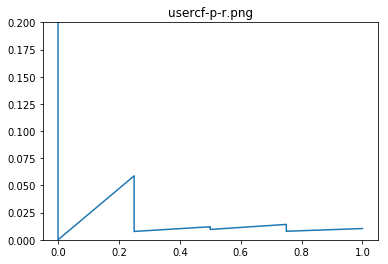

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.408248               07月16日 巨神战击队第三季
3     10004        203        0.235702                   08月05日 熊熊乐园
23    10004        212        0.235702                 08月19日 汪汪队立大功
54    10004         94        0.235702                         浪花一朵朵
74    10004        122        0.235702               07月18日 巨神战击队第三季
103   10004        152        0.235702                         名侦探柯南
5     10012        203        0.841729                   08月05日 熊熊乐园
230   10012        151        0.524377                          饥饿游戏
105   10012        152        0.439826                         名侦探柯南
290   10012        181        0.340207                   07月28日 神兽金刚
76    10012        122        0.317352               07月18日 巨神战击队第三季
301   10012        209        0.288675                   08月10日 小猪佩奇
309   10012        138        0.288675                            花咒
204   10012        134       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 202
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 724
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0645	coverage=0.0000	popularity=0.9723


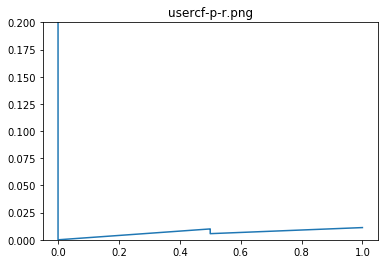

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        203        0.235702                   08月05日 熊熊乐园
40    10004        212        0.235702                 08月19日 汪汪队立大功
71    10004         94        0.235702                         浪花一朵朵
94    10004        122        0.235702               07月18日 巨神战击队第三季
140   10004        152        0.235702                         名侦探柯南
182   10004        144        0.113228                         迪迦奥特曼
187   10004        192        0.113228                   07月25日 小猪佩奇
191   10004         90        0.113228                         疯狂原始人
196   10004        184        0.113228             06月28日 新大头儿子和小头爸爸
201   10004        167        0.113228                          足球小将
2     10012        203        0.975585                   08月05日 熊熊乐园
142   10012        152        0.481806                         名侦探柯南
250   10012        151        0.435751                          饥饿游戏
394   10012        181       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 198
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 830
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0645	coverage=0.0000	popularity=1.0631


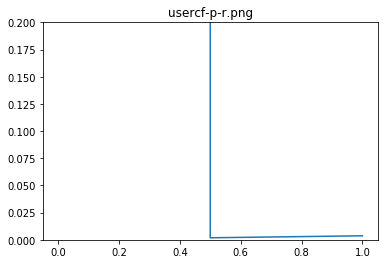

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.408248               07月16日 巨神战击队第三季
3     10004        203        0.288675                   08月05日 熊熊乐园
43    10004         94        0.288675                         浪花一朵朵
66    10004        152        0.288675                         名侦探柯南
87    10004        144        0.113228                         迪迦奥特曼
95    10004        192        0.113228                   07月25日 小猪佩奇
100   10004         90        0.113228                         疯狂原始人
109   10004        184        0.113228             06月28日 新大头儿子和小头爸爸
116   10004        167        0.113228                          足球小将
119   10004         15        0.113228                     魔法俏佳人 第一季
8     10012        203        0.538675                   08月05日 熊熊乐园
69    10012        152        0.538675                         名侦探柯南
498   10012        181        0.426777                   07月28日 神兽金刚
509   10012        209       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 207
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 636
Evaluation start...
recommended for 0 users
precision=0.0043	recall=0.1481	coverage=0.0000	popularity=0.9644


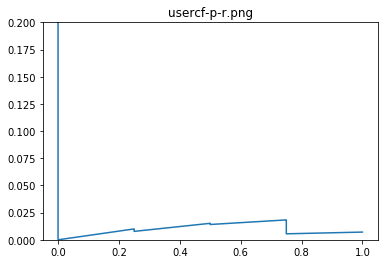

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                    ProgramName
0     10004        121        0.408248                07月16日 巨神战击队第三季
3     10004        203        0.258199                    08月05日 熊熊乐园
42    10004        212        0.258199                  08月19日 汪汪队立大功
60    10004         94        0.258199                          浪花一朵朵
81    10004        122        0.258199                07月18日 巨神战击队第三季
124   10004        144        0.109109                          迪迦奥特曼
129   10004        192        0.109109                    07月25日 小猪佩奇
134   10004         90        0.109109                          疯狂原始人
142   10004        184        0.109109              06月28日 新大头儿子和小头爸爸
147   10004        167        0.109109                           足球小将
229   10012        151        0.703526                           饥饿游戏
5     10012        203        0.445327                    08月05日 熊熊乐园
407   10012        112        0.258199     07月14日 中国新歌声 第二季：杰伦Eason对唱
424   10012    

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 200
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 744
Evaluation start...
recommended for 0 users
precision=0.0040	recall=0.1212	coverage=0.0000	popularity=0.9922


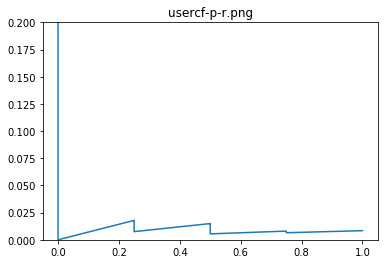

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.500000               07月16日 巨神战击队第三季
4     10004        203        0.288675                   08月05日 熊熊乐园
38    10004        212        0.288675                 08月19日 汪汪队立大功
70    10004         94        0.288675                         浪花一朵朵
95    10004        122        0.288675               07月18日 巨神战击队第三季
137   10004        152        0.288675                         名侦探柯南
237   10012        151        0.637605                          饥饿游戏
343   10012        209        0.288675                   08月10日 小猪佩奇
139   10012        152        0.235702                         名侦探柯南
351   10012        112        0.235702    07月14日 中国新歌声 第二季：杰伦Eason对唱
367   10012         63        0.235702  07月15日 快乐大本营：Angelababy嗨玩双截棍
369   10012         65        0.235702     07月22日 快乐大本营：范爷胡歌送祝福惹哭何老师
371   10012        138        0.235702                            花咒
378   10012        100       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 203
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 770
Evaluation start...
recommended for 0 users
precision=0.0050	recall=0.1471	coverage=0.0000	popularity=0.9836


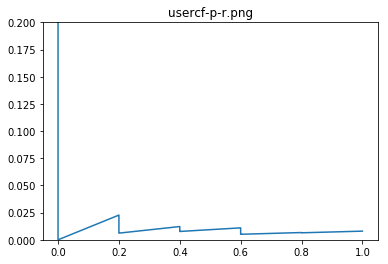

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.408248               07月16日 巨神战击队第三季
1     10004        212        0.258199                 08月19日 汪汪队立大功
18    10004         94        0.258199                         浪花一朵朵
32    10004        122        0.258199               07月18日 巨神战击队第三季
57    10004        152        0.258199                         名侦探柯南
91    10004        192        0.109109                   07月25日 小猪佩奇
93    10004         90        0.109109                         疯狂原始人
96    10004        184        0.109109             06月28日 新大头儿子和小头爸爸
99    10004        167        0.109109                          足球小将
101   10004         15        0.109109                     魔法俏佳人 第一季
59    10012        152        0.774597                         名侦探柯南
171   10012        203        0.689897                   08月05日 熊熊乐园
205   10012        151        0.689897                          饥饿游戏
294   10012        181       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 208
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 680
Evaluation start...
recommended for 0 users
precision=0.0063	recall=0.2069	coverage=0.0000	popularity=0.9513


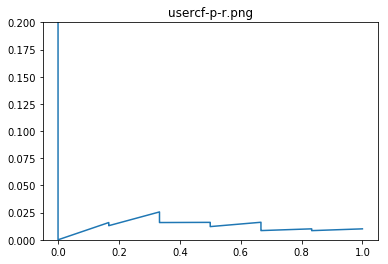

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.408248               07月16日 巨神战击队第三季
2     10004        203        0.235702                   08月05日 熊熊乐园
35    10004        212        0.235702                 08月19日 汪汪队立大功
67    10004         94        0.235702                         浪花一朵朵
82    10004        122        0.235702               07月18日 巨神战击队第三季
122   10004        152        0.235702                         名侦探柯南
157   10004        144        0.111111                         迪迦奥特曼
164   10004        192        0.111111                   07月25日 小猪佩奇
168   10004         90        0.111111                         疯狂原始人
174   10004        184        0.111111             06月28日 新大头儿子和小头爸爸
4     10012        203        0.728502                   08月05日 熊熊乐园
123   10012        152        0.675529                         名侦探柯南
83    10012        122        0.348930               07月18日 巨神战击队第三季
267   10012        151       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 201
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 732
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0645	coverage=0.0000	popularity=0.9746


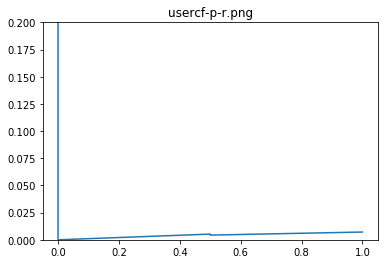

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                   ProgramName
0     10004        121        0.408248               07月16日 巨神战击队第三季
3     10004        203        0.258199                   08月05日 熊熊乐园
43    10004        212        0.258199                 08月19日 汪汪队立大功
78    10004        122        0.258199               07月18日 巨神战击队第三季
121   10004        152        0.258199                         名侦探柯南
161   10004        144        0.117851                         迪迦奥特曼
164   10004        192        0.117851                   07月25日 小猪佩奇
166   10004        184        0.117851             06月28日 新大头儿子和小头爸爸
170   10004        167        0.117851                          足球小将
172   10004         15        0.117851                     魔法俏佳人 第一季
5     10012        203        0.913504                   08月05日 熊熊乐园
123   10012        152        0.740005                         名侦探柯南
230   10012        151        0.689897                          饥饿游戏
392   10012        181       

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 198
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 806
Evaluation start...
recommended for 0 users
precision=0.0031	recall=0.0968	coverage=0.0000	popularity=1.0365


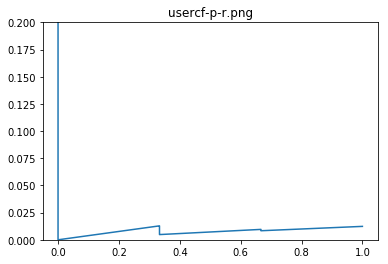

Similar user number = 20
recommended movie number = 10


None
     UserNo  ProgramNo  RecommendScore                    ProgramName
0     10004        121        0.408248                07月16日 巨神战击队第三季
3     10004        144        0.111111                          迪迦奥特曼
8     10004        192        0.111111                    07月25日 小猪佩奇
12    10004         90        0.111111                          疯狂原始人
20    10004        184        0.111111              06月28日 新大头儿子和小头爸爸
25    10004        167        0.111111                           足球小将
29    10004         15        0.111111                      魔法俏佳人 第一季
32    10004         26        0.111111                        爱丽丝梦游仙境
34    10004         30        0.111111                             雄狮
36    10004         32        0.111111                           你的名字
123   10012        203        0.833911                    08月05日 熊熊乐园
158   10012        152        0.675529                          名侦探柯南
194   10012        151        0.629787                           饥饿游戏
223   10012    

split training set and test set succ
train set = 315
test set = 35
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 202
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 670
Evaluation start...
recommended for 0 users
precision=0.0065	recall=0.2222	coverage=0.0000	popularity=1.0076


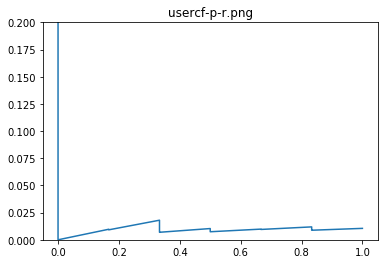

None
Populating the interactive namespace from numpy and matplotlib


FileNotFoundError: No such file or directory: 'user-p-r.png'

FileNotFoundError: No such file or directory: 'user-p-r.png'

<IPython.core.display.Image object>

In [318]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=10,shuffle=True,random_state=1024)#10折交叉验证划分数据集
for train,test in kfold.split(full_data):
    user_cf_model = usercf.UserBasedCF() #利用usercf.py
    user_cf_model.generate_dataset(full_data.iloc[train],full_data.iloc[test])
    user_cf_model.calc_user_sim()
    acc_list = []

    for user in user_cf_model.trainset:
        tmp_rs = np.array([(user, a, b) for a,b in  user_cf_model.recommend(user)])
        if tmp_rs.shape[0] > 0:
            acc_list.append(tmp_rs)
    
    final_df = pd.DataFrame(np.concatenate(acc_list), columns=['UserNo', 'ProgramNo', 'RecommendScore'])
    final_df['UserNo'] = final_df.UserNo.astype('int32')
    final_df['ProgramNo'] = final_df.ProgramNo.astype('int32')

    final_df = final_df.merge(movie_df, left_on='ProgramNo', right_on='index')
    del final_df['index']
    final_df = final_df.sort_values(['UserNo', 'RecommendScore'], ascending=[True, False])
    print(final_df)
    print(user_cf_model.evaluate()) #模型评估
%pylab inline
from IPython.display import Image#导入Image类库，方便将图片内嵌在jupyter里面
Image('user-p-r.png')


In [311]:
final_df.to_csv('基于用户的协同过滤-观看频次.csv', encoding='utf8') 

In [168]:
indexx = temp2.index.values.tolist()
features = temp2.columns.values.tolist()
temp22 = pd.DataFrame()

In [169]:
for i in features:
    for j in indexx:
        if temp2[i][j] > 0:
            temp22 = temp22.append(pd.DataFrame([j,i,temp2[i][j]]).T, ignore_index=True) #在temp22中附加数据

In [170]:
temp22[0] = pd.Categorical(temp22[0])
temp22['ProgramNo'] = temp22[0].cat.codes
print(temp22['ProgramNo'].unique().shape)

(2711,)


In [171]:
temp22.head()

,0,1,2,ProgramNo
0,06月12日 超级飞侠,10003,1046,251
1,06月27日 熊出没之春日对对碰,10003,1334,320
2,07月28日 小猪佩奇,10003,602,570
3,07月29日 小猪佩奇,10003,1445,581
4,08月02日 小猪佩奇,10003,1530,616


In [172]:
temp22.columns = ['ProgramName','UserNo','Score','ProgramNo']

In [173]:
movie_df1 = pd.DataFrame(temp22["ProgramName"].unique(), columns=["ProgramName"]).reset_index()
full_data1 = temp22.merge(movie_df1, left_on="ProgramName", right_on="ProgramName")
del full_data1['index']
full_data1.head()

,ProgramName,UserNo,Score,ProgramNo
0,06月12日 超级飞侠,10003,1046,251
1,06月12日 超级飞侠,10763,245,251
2,06月12日 超级飞侠,11084,1283,251
3,06月27日 熊出没之春日对对碰,10003,1334,320
4,06月27日 熊出没之春日对对碰,10148,4008,320


Similar user number = 20
recommended movie number = 10
split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2595
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 39904
Evaluation start...
recommended for 0 users
precision=0.0279	recall=0.1185	coverage=0.0000	popularity=3.1778


      UserNo  ProgramNo  RecommendScore                      ProgramName
0      10003        553        0.625728        08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
6      10003       2550        0.611166                            冲出康普顿
99     10003        600        0.602831        08月06日 极限挑战 第三季：五美惊喜空降男人帮
102    10003        568        0.596674                             暗黑杀神
172    10003       1348        0.557580                    哈利波特3：阿兹卡班的逃犯
339    10003        548        0.426713                               追捕
345    10003       1576        0.426713                          我们的世界大战
350    10003        609        0.421263         09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
355    10003       1947        0.406424             黎明2011年LEON-X-U红馆演唱会
490    10003       1502        0.382168                  07月16日 巨神战击队第三季
421    10012       1947        0.979066             黎明2011年LEON-X-U红馆演唱会
1982   10012       1681        0.565236                   08月25日 巴巴爸爸的探险
866    10012       2538        0.511861            

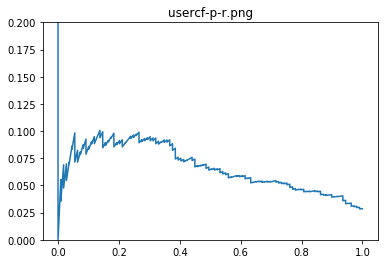

None


Similar user number = 20
recommended movie number = 10
split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2595
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 40852
Evaluation start...
recommended for 0 users
precision=0.0263	recall=0.1112	coverage=0.0000	popularity=3.1862


      UserNo  ProgramNo  RecommendScore                  ProgramName
0      10003        548        0.876581                           追捕
4      10003        600        0.876581    08月06日 极限挑战 第三季：五美惊喜空降男人帮
7      10003        636        0.669983                     贫民窟的百万富翁
12     10003       2550        0.655312                        冲出康普顿
119    10003       1174        0.624537          07月06日 今晚80后脱口秀：责任心
229    10003        627        0.616448                        暖暖内含光
233    10003        690        0.616448                         寻人大师
239    10003        553        0.606877    08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
242    10003        647        0.466731   09月15日 极速前进 第四季：张继科化身战神接飞米
244    10003        609        0.466330     09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
1662   10012       1947        1.179563         黎明2011年LEON-X-U红馆演唱会
686    10012       1691        0.786059                          捉妖记
519    10012       2538        0.623456                          太极2
919    10012       1681        0.5

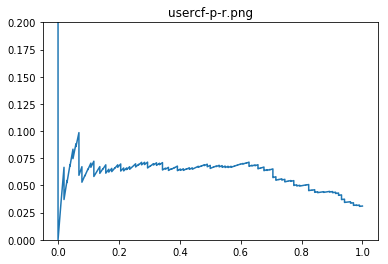

None


Similar user number = 20
recommended movie number = 10
split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2578
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 40062
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                  ProgramName
0      10003        548        1.165772                           追捕
4      10003        636        1.165772                     贫民窟的百万富翁
8      10003        553        0.941815    08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
14     10003        600        0.875113    08月06日 极限挑战 第三季：五美惊喜空降男人帮
18     10003        690        0.875113                         寻人大师
27     10003       1174        0.871001          07月06日 今晚80后脱口秀：责任心
137    10003       2471        0.784554                  08月09日 神奇阿呦
250    10003        609        0.744978     09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
253    10003       1348        0.727519                哈利波特3：阿兹卡班的逃犯
409    10003        568        0.727144                         暗黑杀神
892    10012       1691        0.561677                          捉妖记
567    10012       2538        0.547755                          太极2
1733   10012       1947        0.478327         黎明2011年LEON-X-U红馆演唱会
3398   10012       2532        0.4

precision=0.0270	recall=0.1150	coverage=0.0000	popularity=3.1683


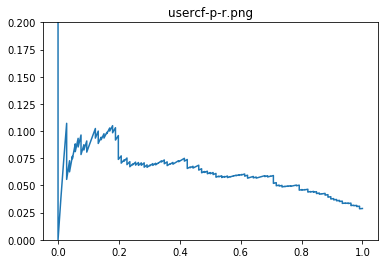

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2601
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 41162
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                      ProgramName
0      10003        600        1.380882        08月06日 极限挑战 第三季：五美惊喜空降男人帮
5      10003        553        1.175125        08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
11     10003        548        0.974482                               追捕
15     10003        609        0.974482         09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
20     10003        636        0.918096                         贫民窟的百万富翁
25     10003        592        0.890793                             新侠客行
28     10003        690        0.888412                             寻人大师
35     10003        561        0.857399                             冰川鲨鱼
41     10003       1174        0.692296              07月06日 今晚80后脱口秀：责任心
142    10003        730        0.666978                               分裂
1680   10012       1947        1.034459             黎明2011年LEON-X-U红馆演唱会
563    10012       1691        0.925378                              捉妖记
395    10012       2538        0.625055            

precision=0.0266	recall=0.1117	coverage=0.0000	popularity=3.1474


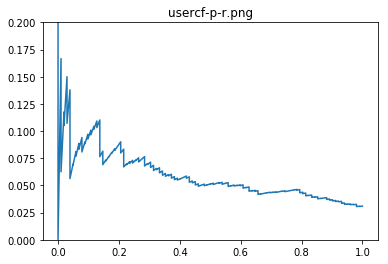

None


Similar user number = 20
recommended movie number = 10
split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2578
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 39970
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                      ProgramName
0      10003        548        1.295919                               追捕
5      10003        636        1.228209                         贫民窟的百万富翁
8      10003        690        1.218196                             寻人大师
16     10003        600        1.179975        08月06日 极限挑战 第三季：五美惊喜空降男人帮
20     10003       1691        1.060162                              捉妖记
219    10003        553        1.011316        08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
225    10003        700        0.982243                       改变世界的武器已剪辑
232    10003        609        0.974536         09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
238    10003        659        0.950186                        特别呈现：熊猫宝宝
243    10003        561        0.875315                             冰川鲨鱼
1375   10012       1947        0.890046             黎明2011年LEON-X-U红馆演唱会
588    10012       2538        0.799638                              太极2
66     10012       1691        0.724718            

precision=0.0306	recall=0.1292	coverage=0.0000	popularity=3.1484


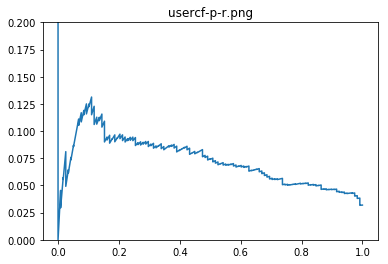

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2592
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 40482
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                  ProgramName
172    10003       2550        0.767771                        冲出康普顿
274    10003       1947        0.703328         黎明2011年LEON-X-U红馆演唱会
127    10003        636        0.480528                     贫民窟的百万富翁
401    10003        548        0.480528                           追捕
405    10003        600        0.480528    08月06日 极限挑战 第三季：五美惊喜空降男人帮
408    10003        568        0.435251                         暗黑杀神
464    10003       2471        0.426662                  08月09日 神奇阿呦
596    10003       1150        0.354787                  08月29日 神奇阿呦
681    10003       2260        0.351471                  超级玛丽的世界轮子风波
696    10003       2706        0.345819                        黑色大丽花
332    10012       1947        1.069300         黎明2011年LEON-X-U红馆演唱会
906    10012       1691        0.784563                          捉妖记
1164   10012       2538        0.668248                          太极2
1543   10012       1681        0.5

precision=0.0251	recall=0.1059	coverage=0.0000	popularity=3.1686


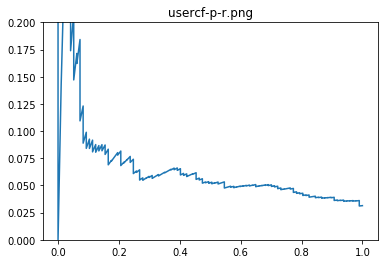

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2587
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 41074
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                  ProgramName
0      10003       1947        0.743098         黎明2011年LEON-X-U红馆演唱会
136    10003        636        0.704021                     贫民窟的百万富翁
143    10003       1174        0.599953          07月06日 今晚80后脱口秀：责任心
232    10003       2471        0.593518                  08月09日 神奇阿呦
346    10003       1576        0.528556                      我们的世界大战
350    10003        553        0.450475    08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
357    10003        600        0.450475    08月06日 极限挑战 第三季：五美惊喜空降男人帮
360    10003        609        0.450475     09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
363    10003        568        0.444040                         暗黑杀神
426    10003        548        0.429012                           追捕
61     10012       1947        1.063663         黎明2011年LEON-X-U红馆演唱会
885    10012       1691        0.839629                          捉妖记
526    10012       2538        0.681593                          太极2
1609   10012        451        0.5

precision=0.0243	recall=0.1033	coverage=0.0000	popularity=3.1301


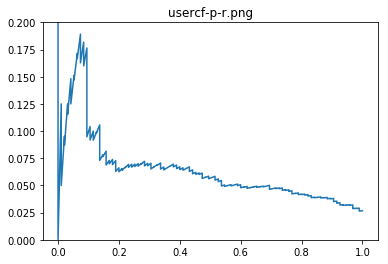

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8314
test set = 924
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2586
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 40938
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                  ProgramName
0      10003        548        0.971444                           追捕
5      10003        600        0.971444    08月06日 极限挑战 第三季：五美惊喜空降男人帮
9      10003        636        0.971444                     贫民窟的百万富翁
15     10003        553        0.964645    08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
19     10003       2550        0.723257                        冲出康普顿
122    10003       1174        0.661986          07月06日 今晚80后脱口秀：责任心
228    10003       2471        0.624545                  08月09日 神奇阿呦
340    10003        592        0.607846                         新侠客行
344    10003       2204        0.605423                 09月19日 猫村狂想曲
355    10003       1681        0.592476               08月25日 巴巴爸爸的探险
779    10012       1691        0.978358                          捉妖记
594    10012       2538        0.896299                          太极2
1696   10012       1947        0.660460         黎明2011年LEON-X-U红馆演唱会
2234   10012       1502        0.6

precision=0.0224	recall=0.0948	coverage=0.0000	popularity=3.1845


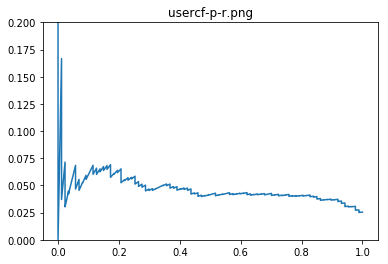

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8315
test set = 923
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2581
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 40794
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                      ProgramName
0      10003        600        1.181201        08月06日 极限挑战 第三季：五美惊喜空降男人帮
2      10003        636        1.181201                         贫民窟的百万富翁
7      10003        553        0.977077        08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
14     10003        609        0.977077         09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
19     10003        690        0.877713                             寻人大师
29     10003        548        0.783639                               追捕
34     10003       1174        0.711605              07月06日 今晚80后脱口秀：责任心
141    10003        700        0.601686                       改变世界的武器已剪辑
145    10003        669        0.586544                             窈窕绅士
148    10003        568        0.579515                             暗黑杀神
2780   10012       1947        1.181021             黎明2011年LEON-X-U红馆演唱会
619    10012       1691        0.732919                              捉妖记
303    10012       2538        0.701965            

precision=0.0302	recall=0.1283	coverage=0.0000	popularity=3.1253


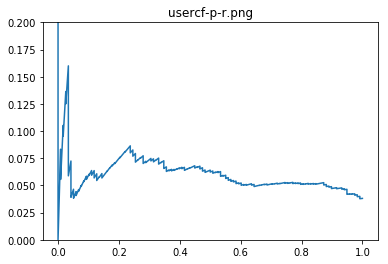

Similar user number = 20
recommended movie number = 10


None


split training set and test set succ
train set = 8315
test set = 923
building movie-users inverse table...
build movie-users inverse table succ
total movie number = 2592
building user co-rated movies matrix...
build user co-rated movies matrix succ
calculating user similarity matrix...
calculate user similarity matrix(similarity factor) succ
Total similarity factor number = 41082
Evaluation start...
recommended for 0 users


      UserNo  ProgramNo  RecommendScore                      ProgramName
0      10003        548        0.709876                               追捕
8      10003        600        0.709876        08月06日 极限挑战 第三季：五美惊喜空降男人帮
13     10003        636        0.709876                         贫民窟的百万富翁
19     10003        553        0.707746        08月11日 我们来了 第二季：唐艺昕陈妍希玩亲亲
24     10003        568        0.703917                             暗黑杀神
95     10003       1174        0.622236              07月06日 今晚80后脱口秀：责任心
178    10003        609        0.518221         09月16日 中餐厅：赵薇接任“主厨”遇岛主光临
183    10003       1167        0.454398                            飓风营救3
203    10003        592        0.454268                             新侠客行
207    10003        690        0.454268                             寻人大师
1661   10012       1947        1.024684             黎明2011年LEON-X-U红馆演唱会
538    10012       1691        0.802578                              捉妖记
897    10012       2538        0.769075            

precision=0.0251	recall=0.1065	coverage=0.0000	popularity=3.1081


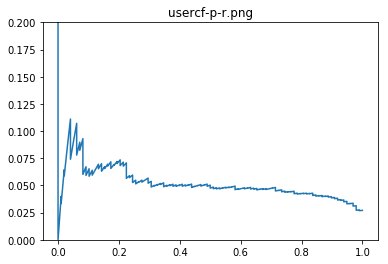

None
Populating the interactive namespace from numpy and matplotlib


In [175]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=10,shuffle=True,random_state=1024)#10折交叉验证划分数据集
for train,test in kfold.split(full_data1):
    user_cf_model = usercf.UserBasedCF() #利用usercf.py
    user_cf_model.generate_dataset(full_data1.iloc[train],full_data1.iloc[test])
    user_cf_model.calc_user_sim()
    acc_list = []

    for user in user_cf_model.trainset:
        tmp_rs = np.array([(user, a, b) for a,b in  user_cf_model.recommend(user)])
        if tmp_rs.shape[0] > 0:
            acc_list.append(tmp_rs)
    
    final_df = pd.DataFrame(np.concatenate(acc_list), columns=['UserNo', 'ProgramNo', 'RecommendScore'])
    final_df['UserNo'] = final_df.UserNo.astype('int32')
    final_df['ProgramNo'] = final_df.ProgramNo.astype('int32')

    final_df = final_df.merge(movie_df1, left_on='ProgramNo', right_on='index')
    del final_df['index']
    final_df= final_df.sort_values(['UserNo', 'RecommendScore'], ascending=[True, False])
    print(final_df)
    print(user_cf_model.evaluate()) #模型评估
%pylab inline
from IPython.display import Image#导入Image类库，方便将图片内嵌在jupyter里面

In [176]:
final_df.to_csv('基于用户的协同过滤-观看时长.csv', encoding='utf8') 

# 基于电视产品的协同过滤

In [327]:
temp1 = jiemu_pinci #频次

In [328]:
jiemu_pinci_cor1 = temp1.corr() # pearson相关系数
jiemu_pinci_cor2 = temp1.corr('kendall') # Kendall Tau相关系数
jiemu_pinci_cor3 = temp1.corr('spearman') # spearman秩相关

In [329]:
temp2 = jiemu_shichang#时长

In [330]:
jiemu_shichang_cor1 = temp2.corr() # pearson相关系数
jiemu_shichang_cor2 = temp2.corr('kendall') # Kendall Tau相关系数
jiemu_shichang_cor3 = temp2.corr('spearman') # spearman秩相关

In [331]:
indexx = temp1.index.values.tolist()
features = temp1.columns.values.tolist()
temp11 = pd.DataFrame()

In [332]:
for i in features:
    for j in indexx:
        if temp1[i][j] > 0:
            temp11 = temp11.append(pd.DataFrame([j,i,temp1[i][j]]).T, ignore_index=True)

In [333]:
temp11[1] = pd.Categorical(temp11[1])
temp11['ProgramNo'] = temp11[1].cat.codes
#print(temp22['ProgramNo'].unique().shape)
temp11.head()

,0,1,2,ProgramNo
0,10273,03月10日 王牌对王牌 第二季：爱情公寓8周年重聚,1,0
1,10273,03月25日 王牌对王牌 第二季：王源演技爆发成烈士,1,1
2,10273,03月31日 王牌对王牌 第二季：王源林俊杰隔空互动,1,2
3,10273,04月07日 王牌对王牌 第二季：王源魔幻弹唱 贾玲辣眼cos白浅,1,3
4,10138,05月05日 快乐大巴,1,4


In [334]:
temp11.columns = ['UserNo','ProgramName','Score','ProgramNo']
temp11.head()

,UserNo,ProgramName,Score,ProgramNo
0,10273,03月10日 王牌对王牌 第二季：爱情公寓8周年重聚,1,0
1,10273,03月25日 王牌对王牌 第二季：王源演技爆发成烈士,1,1
2,10273,03月31日 王牌对王牌 第二季：王源林俊杰隔空互动,1,2
3,10273,04月07日 王牌对王牌 第二季：王源魔幻弹唱 贾玲辣眼cos白浅,1,3
4,10138,05月05日 快乐大巴,1,4


In [335]:
movie_df2 = pd.DataFrame(temp11["ProgramName"].unique(), columns=["ProgramName"]).reset_index()
full_data2 = temp11.merge(movie_df2, left_on="ProgramName", right_on="ProgramName")
del full_data2['index']
full_data2.head()

,UserNo,ProgramName,Score,ProgramNo
0,10273,03月10日 王牌对王牌 第二季：爱情公寓8周年重聚,1,0
1,10273,03月25日 王牌对王牌 第二季：王源演技爆发成烈士,1,1
2,10273,03月31日 王牌对王牌 第二季：王源林俊杰隔空互动,1,2
3,10273,04月07日 王牌对王牌 第二季：王源魔幻弹唱 贾玲辣眼cos白浅,1,3
4,10138,05月05日 快乐大巴,1,4


Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 196
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2772
Evaluation start...
recommended for 0 users
precision=0.0010	recall=0.0333	coverage=0.0000	popularity=0.7590


     UserNo  ProgramNo  RecommendScore                ProgramName
72    10004         15        0.707107           07月01日 猪猪侠之五灵守卫者
76    10004         26        0.707107            07月16日 巨神战击队第三季
80    10004         28        0.707107            07月18日 巨神战击队第三季
84    10004         30        0.707107            07月19日 巨神战击队第三季
88    10004         32        0.707107            07月20日 巨神战击队第三季
92    10004         34        0.707107            07月21日 赛尔号之幻梦战记
96    10004         84        0.707107                     101次求婚
100   10004         96        0.707107                   傲慢与偏见与僵尸
334   10004         97        0.707107                       冰川鲨鱼
600   10004        110        0.707107                    咕噜咕噜美人鱼
128   10012        147        0.500000             托马斯和他的朋友们 第十五季
150   10012        148        0.500000             托马斯和他的朋友们 第十四季
335   10012         63        0.500000                 08月09日 智慧树
338   10012         65        0.500000                 08月10日 智慧树
341   1001

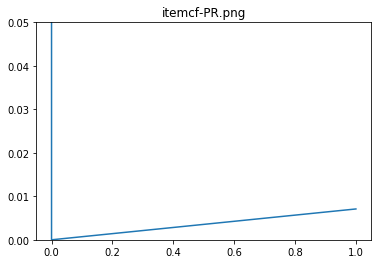

None
     UserNo  ProgramNo  RecommendScore       ProgramName
310   10004         15        0.707107  07月01日 猪猪侠之五灵守卫者
315   10004         26        0.707107   07月16日 巨神战击队第三季
320   10004         28        0.707107   07月18日 巨神战击队第三季
325   10004         30        0.707107   07月19日 巨神战击队第三季
330   10004         32        0.707107   07月20日 巨神战击队第三季
335   10004         34        0.707107   07月21日 赛尔号之幻梦战记
340   10004         39        0.707107      07月24日 超级飞侠二
345   10004         47        0.707107      07月29日 超级飞侠二
350   10004         67        0.707107      08月12日 超级飞侠三
352   10004         84        0.707107            101次求婚
9     10012         63        0.500000        08月09日 智慧树
12    10012         65        0.500000        08月10日 智慧树
15    10012        154        0.500000             曹格演唱会
104   10012          4        0.500000       05月05日 快乐大巴
136   10012        147        0.500000    托马斯和他的朋友们 第十五季
167   10012        148        0.500000    托马斯和他的朋友们 第十四季
388   10012        203    

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 207
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 3068
Evaluation start...
recommended for 0 users
precision=0.0010	recall=0.0323	coverage=0.0000	popularity=0.7043


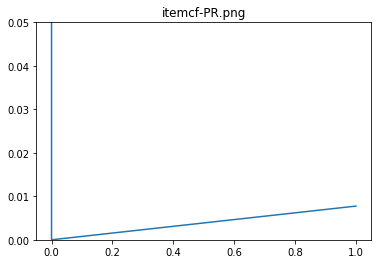

None
     UserNo  ProgramNo  RecommendScore                ProgramName
301   10004         15        0.707107           07月01日 猪猪侠之五灵守卫者
305   10004         26        0.707107            07月16日 巨神战击队第三季
309   10004         28        0.707107            07月18日 巨神战击队第三季
313   10004         30        0.707107            07月19日 巨神战击队第三季
317   10004         32        0.707107            07月20日 巨神战击队第三季
321   10004         34        0.707107            07月21日 赛尔号之幻梦战记
325   10004         39        0.707107               07月24日 超级飞侠二
329   10004         47        0.707107               07月29日 超级飞侠二
333   10004         67        0.707107               08月12日 超级飞侠三
594   10004         84        0.707107                     101次求婚
19    10012         63        0.500000                 08月09日 智慧树
22    10012         65        0.500000                 08月10日 智慧树
25    10012        154        0.500000                      曹格演唱会
121   10012          4        0.500000                05月05日 快乐大巴
148  

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 204
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 3010
Evaluation start...
recommended for 0 users
precision=0.0041	recall=0.1250	coverage=0.0000	popularity=0.7073


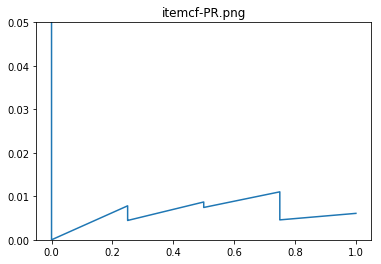

None
     UserNo  ProgramNo  RecommendScore     ProgramName
142   10004         94        0.333333            你的名字
566   10004        121        0.333333       奥特银河大怪兽之战
540   10004        212        0.288675              雄狮
243   10004        122        0.235702             女间谍
408   10004        152        0.204124            新木乃伊
282   10004        203        0.160128          速度与激情8
279   10012        203        0.510203          速度与激情8
21    10012         63        0.500000      08月09日 智慧树
24    10012         65        0.500000      08月10日 智慧树
27    10012        154        0.500000           曹格演唱会
163   10012          4        0.500000     05月05日 快乐大巴
192   10012        147        0.500000  托马斯和他的朋友们 第十五季
218   10012        148        0.500000  托马斯和他的朋友们 第十四季
372   10012        181        0.447214           神偷奶爸3
391   10012        134        0.408114            异星觉醒
265   10012        125        0.353553        小猪佩奇 第三季
33    10025        133        0.707107            幽游白书
42   

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 199
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2746
Evaluation start...
recommended for 0 users
precision=0.0010	recall=0.0323	coverage=0.0000	popularity=0.7135


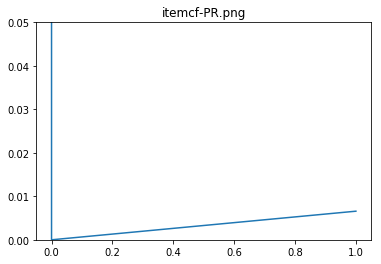

None
     UserNo  ProgramNo  RecommendScore      ProgramName
134   10004         26        0.707107  07月16日 巨神战击队第三季
139   10004         28        0.707107  07月18日 巨神战击队第三季
144   10004         30        0.707107  07月19日 巨神战击队第三季
149   10004         32        0.707107  07月20日 巨神战击队第三季
154   10004         34        0.707107  07月21日 赛尔号之幻梦战记
159   10004         39        0.707107     07月24日 超级飞侠二
164   10004         47        0.707107     07月29日 超级飞侠二
169   10004         67        0.707107     08月12日 超级飞侠三
174   10004         84        0.707107           101次求婚
177   10004         96        0.707107         傲慢与偏见与僵尸
21    10012         65        0.500000       08月10日 智慧树
24    10012        154        0.500000            曹格演唱会
215   10012          4        0.500000      05月05日 快乐大巴
248   10012        125        0.500000         小猪佩奇 第三季
279   10012        147        0.500000   托马斯和他的朋友们 第十五季
308   10012        148        0.500000   托马斯和他的朋友们 第十四季
432   10012        134        0.426777     

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 202
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 3108
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0690	coverage=0.0000	popularity=0.7174


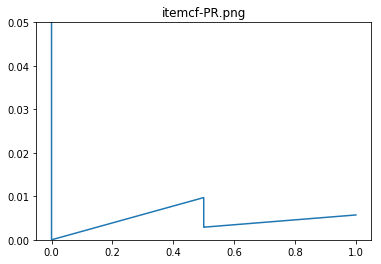

None
     UserNo  ProgramNo  RecommendScore       ProgramName
111   10004         15        0.707107  07月01日 猪猪侠之五灵守卫者
114   10004         28        0.707107   07月18日 巨神战击队第三季
117   10004         30        0.707107   07月19日 巨神战击队第三季
120   10004         32        0.707107   07月20日 巨神战击队第三季
123   10004         34        0.707107   07月21日 赛尔号之幻梦战记
126   10004         39        0.707107      07月24日 超级飞侠二
129   10004         47        0.707107      07月29日 超级飞侠二
132   10004         67        0.707107      08月12日 超级飞侠三
135   10004         84        0.707107            101次求婚
138   10004         96        0.707107          傲慢与偏见与僵尸
492   10012         63        0.577350        08月09日 智慧树
494   10012         65        0.577350        08月10日 智慧树
496   10012        154        0.577350             曹格演唱会
53    10012        112        0.408248  哆啦A梦：大雄的南极冰冰凉大冒险
498   10012         87        0.377964              临时演员
507   10012        145        0.377964            我的英雄学院
513   10012        138    

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 205
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2976
Evaluation start...
recommended for 0 users
precision=0.0000	recall=0.0000	coverage=0.0000	popularity=0.6910
/usr/lib/python3.7/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


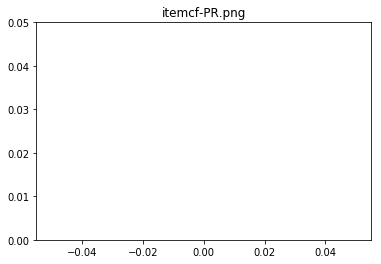

None
     UserNo  ProgramNo  RecommendScore       ProgramName
666   10004         15        0.707107  07月01日 猪猪侠之五灵守卫者
667   10004         26        0.707107   07月16日 巨神战击队第三季
668   10004         28        0.707107   07月18日 巨神战击队第三季
669   10004         30        0.707107   07月19日 巨神战击队第三季
670   10004         39        0.707107      07月24日 超级飞侠二
671   10004         47        0.707107      07月29日 超级飞侠二
672   10004         67        0.707107      08月12日 超级飞侠三
673   10004         97        0.707107              冰川鲨鱼
674   10004        110        0.707107           咕噜咕噜美人鱼
675   10004        136        0.707107         忍者神龟：变种时代
27    10012         63        0.500000        08月09日 智慧树
30    10012         65        0.500000        08月10日 智慧树
33    10012        154        0.500000             曹格演唱会
150   10012          4        0.500000       05月05日 快乐大巴
180   10012        147        0.500000    托马斯和他的朋友们 第十五季
209   10012        148        0.500000    托马斯和他的朋友们 第十四季
408   10012        203    

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 200
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2734
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0645	coverage=0.0000	popularity=0.7505


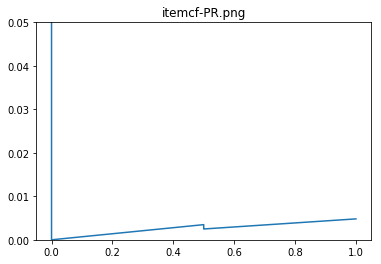

None
     UserNo  ProgramNo  RecommendScore                ProgramName
526   10004        121        0.333333                  奥特银河大怪兽之战
398   10004        212        0.288675                         雄狮
229   10004        122        0.235702                        女间谍
528   10004        152        0.218218                       新木乃伊
450   10004        203        0.166667                     速度与激情8
4     10012         63        0.577350                 08月09日 智慧树
6     10012         65        0.577350                 08月10日 智慧树
8     10012        154        0.577350                      曹格演唱会
148   10012          4        0.577350                05月05日 快乐大巴
178   10012        147        0.577350             托马斯和他的朋友们 第十五季
207   10012        148        0.577350             托马斯和他的朋友们 第十四季
362   10012        181        0.471405                      神偷奶爸3
252   10012         94        0.408248                       你的名字
264   10012        125        0.408248                   小猪佩奇 第三季
273  

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 207
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2968
Evaluation start...
recommended for 0 users
precision=0.0022	recall=0.0800	coverage=0.0000	popularity=0.6663


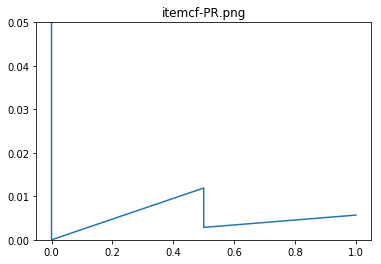

None
     UserNo  ProgramNo  RecommendScore       ProgramName
159   10004         15        0.707107  07月01日 猪猪侠之五灵守卫者
162   10004         26        0.707107   07月16日 巨神战击队第三季
165   10004         28        0.707107   07月18日 巨神战击队第三季
168   10004         30        0.707107   07月19日 巨神战击队第三季
171   10004         32        0.707107   07月20日 巨神战击队第三季
174   10004         34        0.707107   07月21日 赛尔号之幻梦战记
177   10004         39        0.707107      07月24日 超级飞侠二
180   10004         47        0.707107      07月29日 超级飞侠二
327   10004         67        0.707107      08月12日 超级飞侠三
606   10004         84        0.707107            101次求婚
353   10012        181        0.471405             神偷奶爸3
383   10012        152        0.353553              新木乃伊
329   10012        116        0.333333             复仇者联盟
337   10012        153        0.333333              星际穿越
345   10012        206        0.333333             银河护卫队
404   10012        112        0.333333  哆啦A梦：大雄的南极冰冰凉大冒险
416   10012         87    

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 204
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 3068
Evaluation start...
recommended for 0 users
precision=0.0021	recall=0.0667	coverage=0.0000	popularity=0.7307


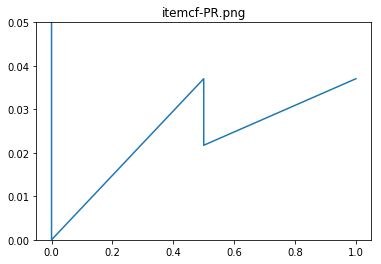

None
     UserNo  ProgramNo  RecommendScore       ProgramName
85    10004         15        0.707107  07月01日 猪猪侠之五灵守卫者
89    10004         26        0.707107   07月16日 巨神战击队第三季
93    10004         28        0.707107   07月18日 巨神战击队第三季
97    10004         30        0.707107   07月19日 巨神战击队第三季
101   10004         32        0.707107   07月20日 巨神战击队第三季
105   10004         34        0.707107   07月21日 赛尔号之幻梦战记
109   10004         39        0.707107      07月24日 超级飞侠二
113   10004         47        0.707107      07月29日 超级飞侠二
117   10004         67        0.707107      08月12日 超级飞侠三
121   10004         84        0.707107            101次求婚
4     10012         63        0.500000        08月09日 智慧树
7     10012        154        0.500000             曹格演唱会
172   10012          4        0.500000       05月05日 快乐大巴
202   10012        147        0.500000    托马斯和他的朋友们 第十五季
232   10012        148        0.500000    托马斯和他的朋友们 第十四季
260   10012        192        0.500000             美好的意外
457   10012        151    

Similar movie number = 20
Recommended movie number = 10
split training set and test set succ
train set = 315
test set = 35
counting movies number and popularity...
count movies number and popularity succ
total movie number = 200
building co-rated users matrix...
build co-rated users matrix succ
calculating movie similarity matrix...
calculate movie similarity matrix(similarity factor) succ
Total similarity factor number = 2696
Evaluation start...
recommended for 0 users
precision=0.0000	recall=0.0000	coverage=0.0000	popularity=0.6872


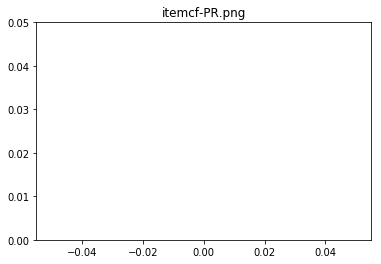

None
Populating the interactive namespace from numpy and matplotlib


In [336]:
import itemcf0422
from sklearn.model_selection import KFold
kfold=KFold(n_splits=10,shuffle=True,random_state=1024)#10折交叉验证划分数据集
for train,test in kfold.split(full_data2):
    item_cf_model = itemcf0422.ItemBasedCF() #利用itemcf.py
    item_cf_model.generate_dataset(full_data2.iloc[train],full_data2.iloc[test])
    item_cf_model.calc_movie_sim()
    acc_list = []
    

    for user in item_cf_model.trainset:
        tmp_rs = np.array([(user, a, b) for a,b in  item_cf_model.recommend(user)])
        if tmp_rs.shape[0] > 0:
            acc_list.append(tmp_rs)
  
    final_df = pd.DataFrame(np.concatenate(acc_list), columns=['UserNo', 'ProgramNo', 'RecommendScore'])
    final_df['UserNo'] = final_df.UserNo.astype('int32')
    final_df['ProgramNo'] = final_df.ProgramNo.astype('int32')

    final_df = final_df.merge(movie_df2, left_on='ProgramNo', right_on='index')
    del final_df['index']
    final_df = final_df.sort_values(['UserNo', 'RecommendScore'], ascending=[True, False])
    print(final_df)
    print(item_cf_model.evaluate()) #模型评估
%pylab inline
from IPython.display import Image#导入Image类库，方便将图片内嵌在jupyter里面


In [193]:
final_df.to_csv('基于物品的协同过滤-观看频次.csv', encoding='utf8') 